In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [2]:
bs = 64
arch = models.resnet50
img_size = 224

In [3]:
path = Path('food-101')
path_img = path/'images'

In [4]:
train_path = 'food-101/meta/train.txt'
test_path = 'food-101/meta/test.txt'

def filelist2df(path):
    df = pd.read_csv(path, delimiter='/', header=None, names=['label', 'name'])
    df['name'] =  df['label'].astype(str) + "/" + df['name'].astype(str) + ".jpg"
    return df

train_df = filelist2df(train_path)
test_df = filelist2df(test_path)

ds_tfms = ([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True), 
            RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)], 
           [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)])


data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_by_rand_pct(0.2)
        .label_from_df(cols=0)
        .transform(ds_tfms, size=224)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [5]:
top_5 = partial(top_k_accuracy, k=5)
learn = cnn_learner(data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph)

In [6]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-02
Min loss divided by 10: 6.92E-03


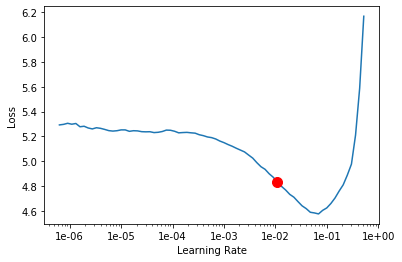

In [7]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.982895,1.656473,0.568383,0.833531,05:47
1,1.708660,1.380981,0.634719,0.869769,05:44
2,1.431846,1.202350,0.682772,0.891947,05:45
3,1.235447,1.075273,0.714984,0.905479,05:44
4,1.096784,1.054530,0.725148,0.908845,05:44


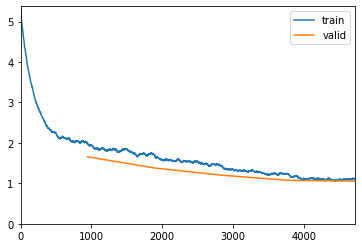

In [8]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))
learn.save('food-101-test-e5')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-05
Min loss divided by 10: 6.31E-08


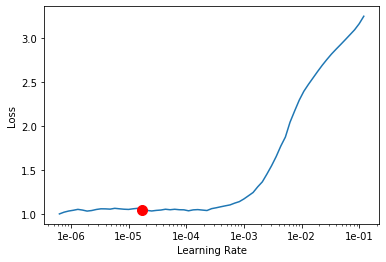

In [9]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.100431,1.056327,0.720330,0.909439,05:55
1,1.085555,1.040160,0.725545,0.910957,05:54
2,0.910621,0.874862,0.767459,0.927921,05:53
3,0.619469,0.783829,0.793267,0.939604,05:54
4,0.535263,0.772051,0.799076,0.941914,05:54


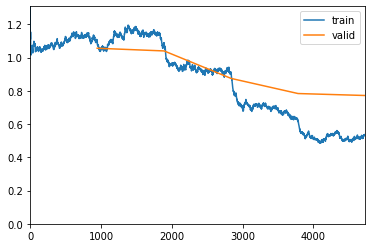

In [10]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))
learn.save('food-101-test-e10')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.506017,0.803736,0.792739,0.939670,05:55
1,0.555684,0.828732,0.789703,0.936370,05:54
2,0.468592,0.821601,0.795710,0.939076,05:54
3,0.353144,0.812569,0.801782,0.940264,05:54
4,0.311632,0.806970,0.803762,0.941188,05:54


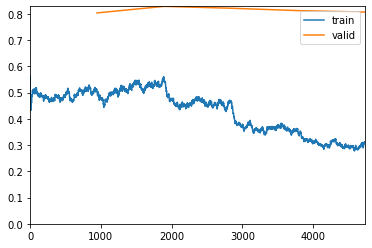

In [11]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-3))
learn.save('food-101-test-e15')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.334778,0.862561,0.796172,0.937822,05:54
1,0.404163,0.880301,0.791353,0.938086,05:55
2,0.306437,0.887303,0.795974,0.938482,05:55
3,0.238497,0.879686,0.803036,0.939472,05:54
4,0.189846,0.886089,0.801980,0.939340,05:53


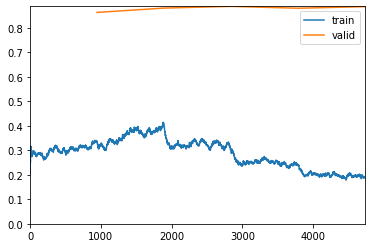

In [12]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-3))
learn.save('food-101-test-e20')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 1.10E-03


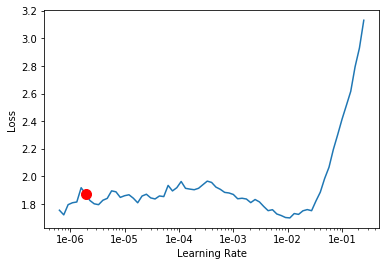

In [14]:
bs=16
data = (ImageList.from_df(df=train_df, path=path/'images', cols=1)
        .split_by_rand_pct(0.2)
        .label_from_df(cols=0)
        .transform(ds_tfms, size=512)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn = cnn_learner(data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph)
learn.load('food-101-test-e20')

learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.332437,0.883398,0.760990,0.935908,21:12
1,1.244029,2.880298,0.730231,0.919274,21:07
2,0.950065,5.356364,0.796370,0.941386,21:08
3,0.680637,4.275558,0.825545,0.949703,21:08
4,0.549617,1.520712,0.845941,0.960924,21:07


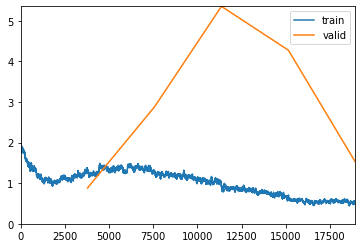

In [15]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-7, 1e-2))
learn.save('food-101-test-e25-512')

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.517110,1.221685,0.845149,0.961320,21:07
1,0.497983,3.015464,0.844026,0.956568,21:07
2,0.456897,3.403201,0.844752,0.956106,21:07
3,0.434991,2.275602,0.852409,0.960990,21:07
4,0.451185,1.863029,0.852607,0.960792,21:08


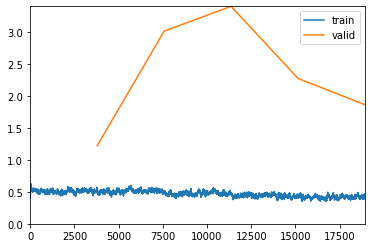

In [16]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-8, 1e-3))
learn.save('food-101-test-e30-512')

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

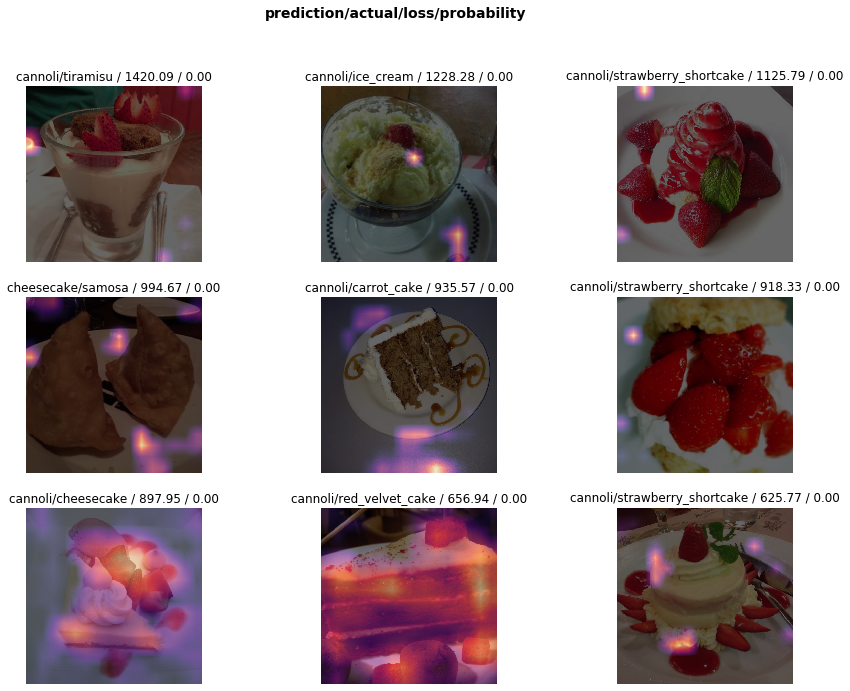

In [19]:
interp.plot_top_losses(9, figsize=(15, 11))

In [20]:
interp.most_confused(min_val=5)

[('filet_mignon', 'steak', 21),
 ('chocolate_mousse', 'chocolate_cake', 19),
 ('poutine', 'peking_duck', 17),
 ('steak', 'filet_mignon', 17),
 ('beef_tartare', 'tuna_tartare', 14),
 ('prime_rib', 'steak', 14),
 ('dumplings', 'gyoza', 13),
 ('baby_back_ribs', 'steak', 12),
 ('donuts', 'beignets', 12),
 ('lobster_bisque', 'clam_chowder', 12),
 ('breakfast_burrito', 'huevos_rancheros', 11),
 ('steak', 'pork_chop', 11),
 ('sushi', 'sashimi', 11),
 ('apple_pie', 'bread_pudding', 10),
 ('chocolate_cake', 'chocolate_mousse', 10),
 ('chocolate_mousse', 'tiramisu', 9),
 ('filet_mignon', 'pork_chop', 9),
 ('pork_chop', 'steak', 9),
 ('ravioli', 'gnocchi', 9),
 ('baby_back_ribs', 'pork_chop', 8),
 ('cheesecake', 'strawberry_shortcake', 8),
 ('greek_salad', 'beet_salad', 8),
 ('grilled_cheese_sandwich', 'club_sandwich', 8),
 ('onion_rings', 'fried_calamari', 8),
 ('panna_cotta', 'chocolate_mousse', 8),
 ('pork_chop', 'club_sandwich', 8),
 ('ramen', 'pho', 8),
 ('red_velvet_cake', 'cannoli', 8),
 (

15124 misclassified samples over 15150 samples in the validation set.


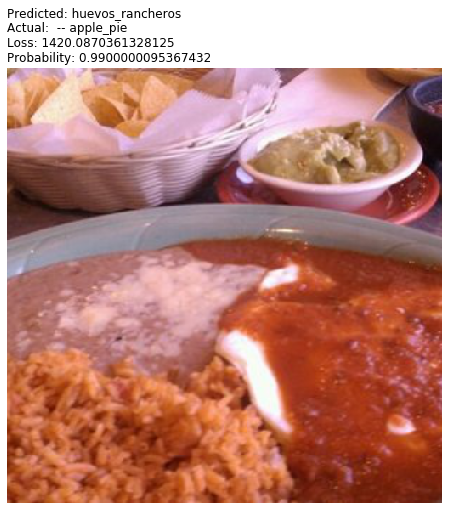

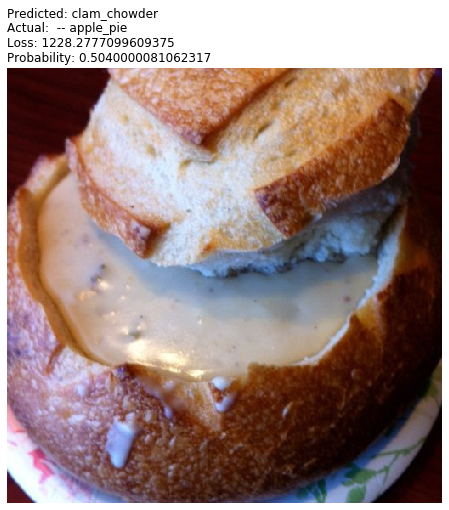

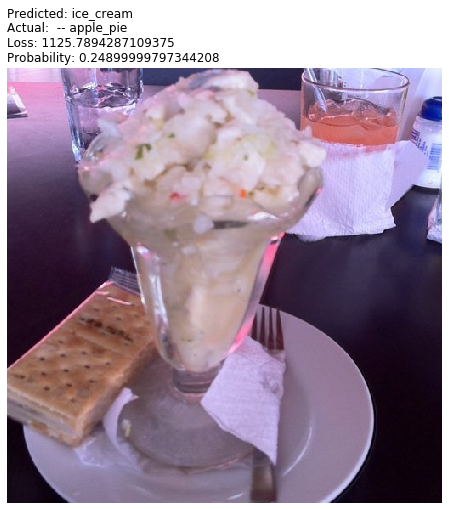

In [21]:
interp.plot_multi_top_losses()

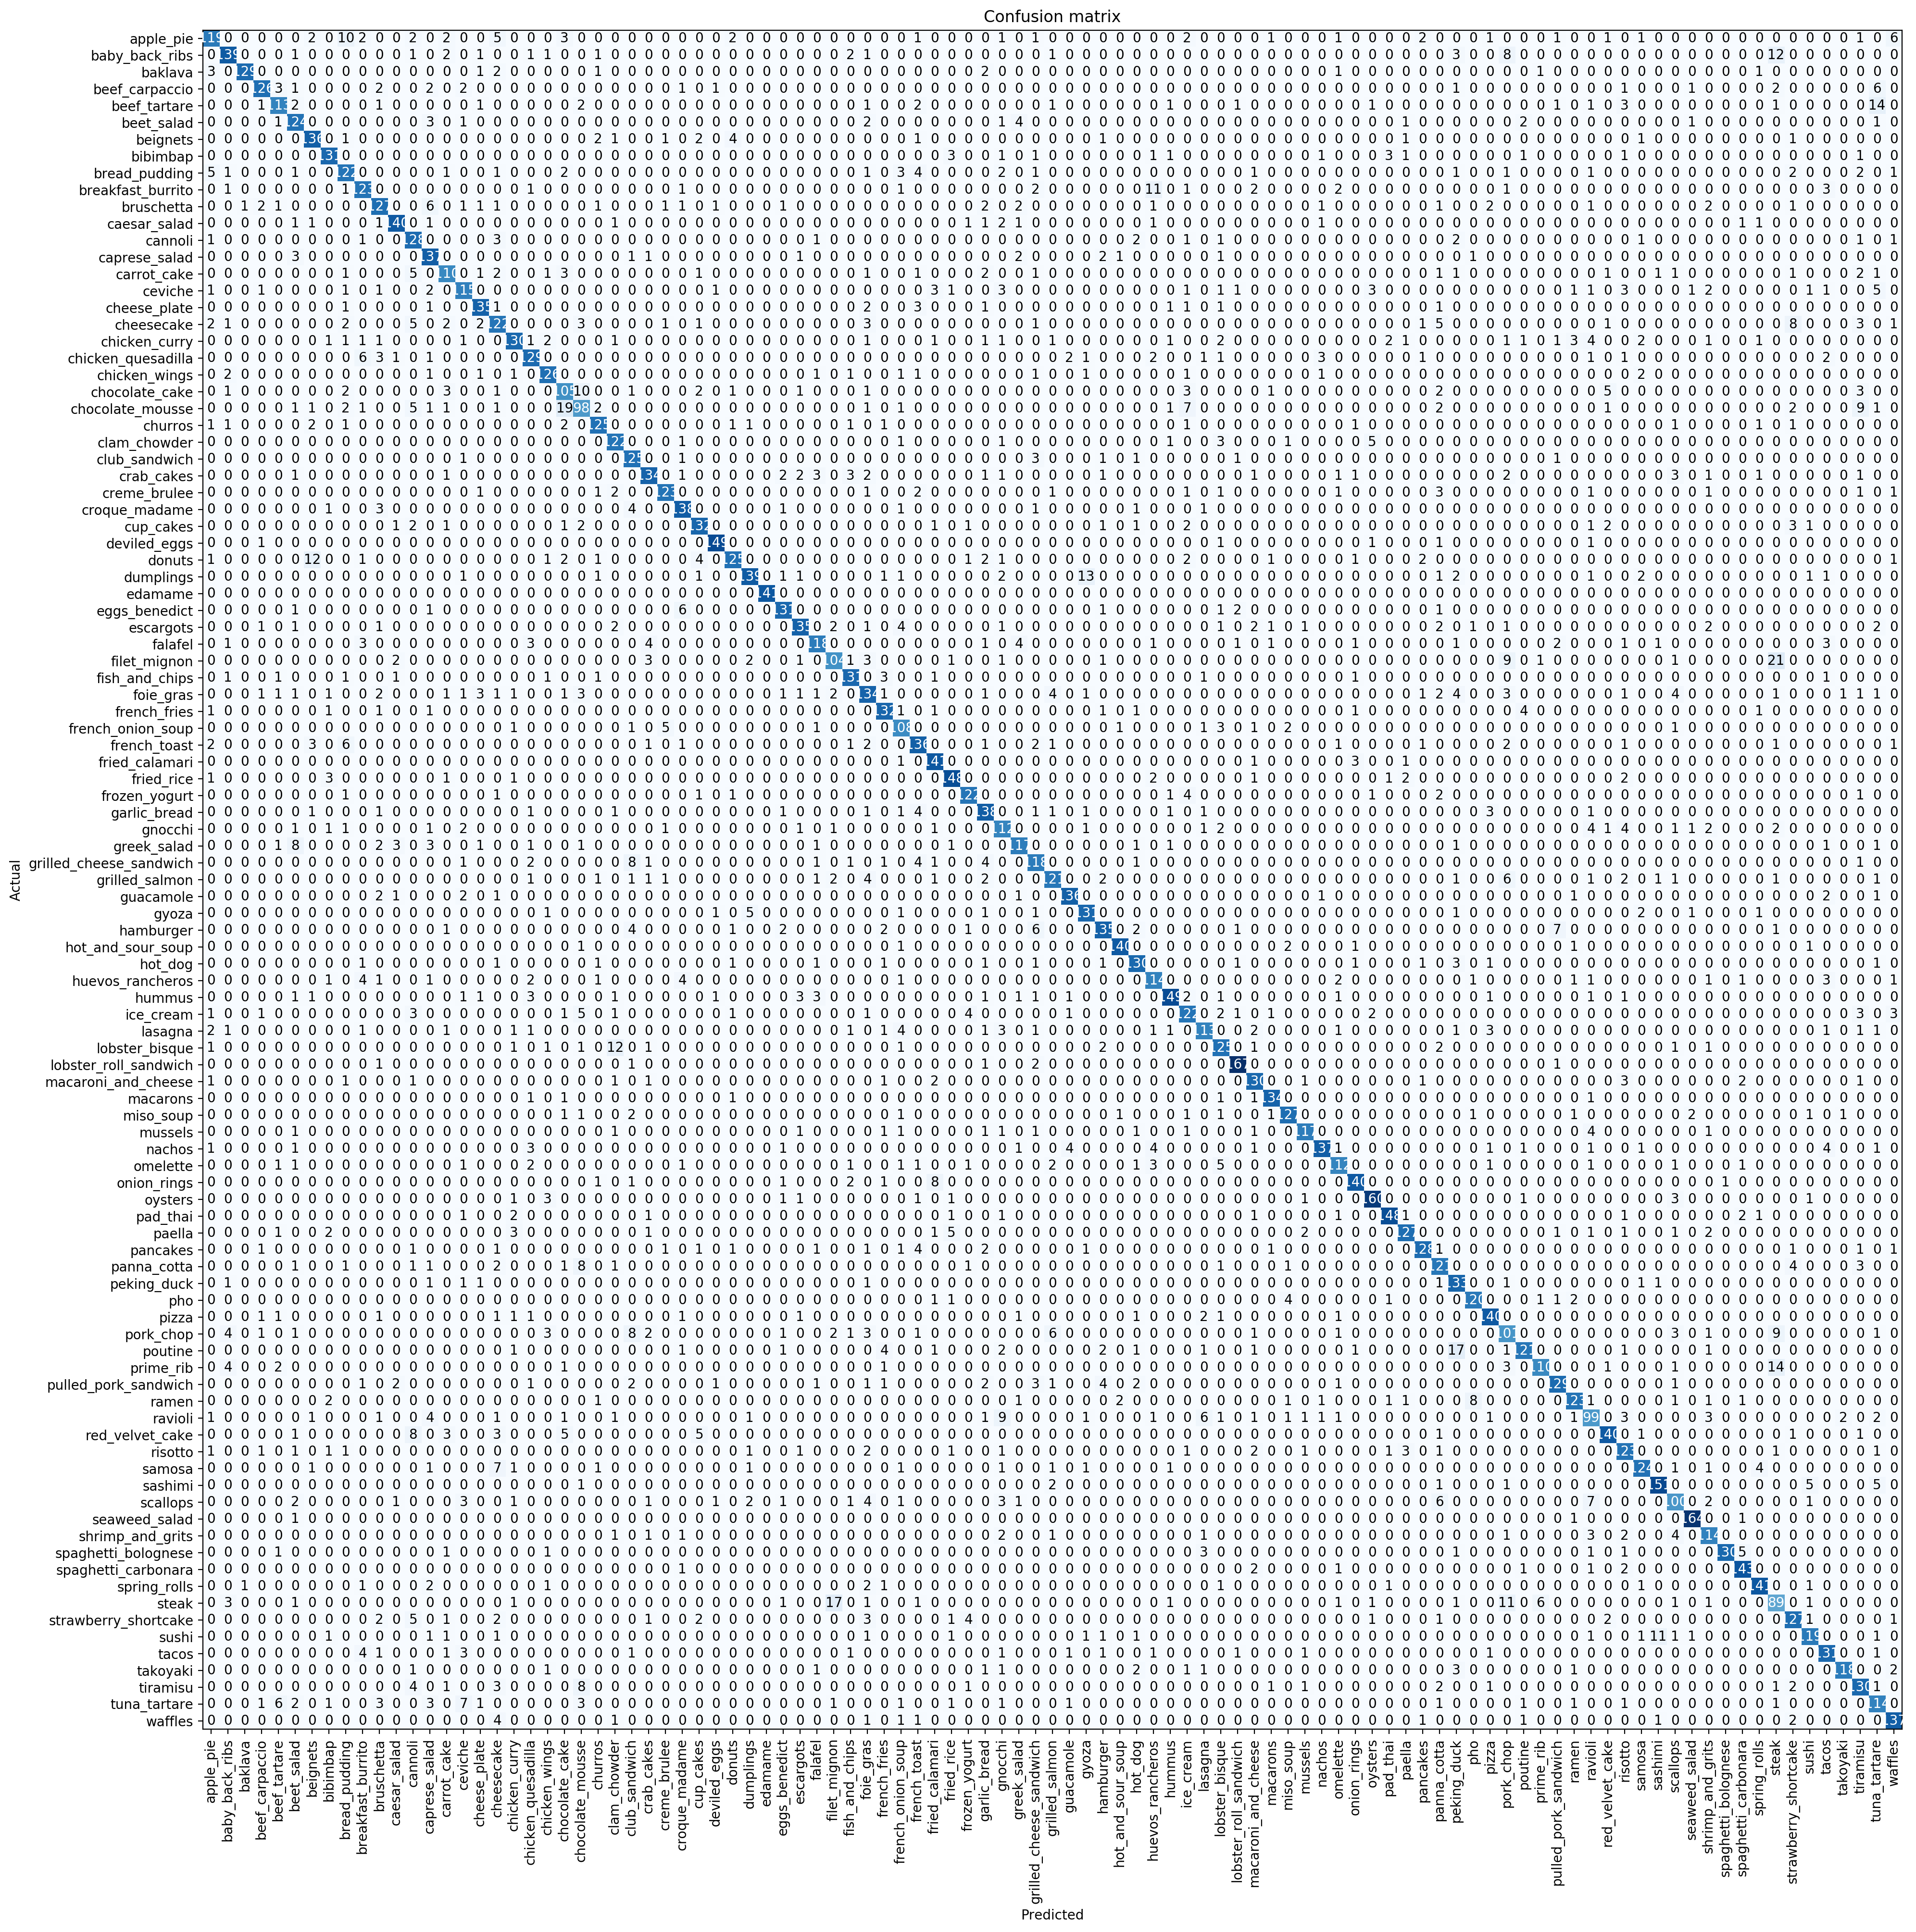

In [22]:
interp.plot_confusion_matrix(figsize=(20, 20), dpi=200)

In [25]:
bs=16
test_data = (ImageList.from_df(df=test_df, path=path/'images', cols=1)
            .split_none()
            .label_from_df(cols=0)
            .transform(size=512)
            .databunch(bs=bs)
            .normalize(imagenet_stats))


learn = cnn_learner(test_data, arch, metrics=[accuracy, top_5], callback_fns=ShowGraph)
learn.load('food-101-test-e30-512')

Learner(data=ImageDataBunch;

Train: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: food-101/images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: food-101/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (b